# 주어진 데이터를 활용하여 Classification

## 1. 기본적인 세팅

### Module Setting

In [1]:
# set module
import pandas as pd
import numpy as np
import tqdm

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# train vaild split
from sklearn.model_selection import train_test_split

# modeling 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# confusion matrix & score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# graph
from matplotlib import pyplot as plt
import seaborn as sns

# oversampling
from imblearn.over_sampling import SMOTE

# imputing
## simple imputation
from sklearn.impute import SimpleImputer

## MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# load data
data = pd.read_csv('../data/loan_train.csv')
test = pd.read_csv('../data/loan_test.csv')

### 분류 전 데이터 속성 확인

- Gender : 성별(남/여)
- Married : 결혼 여부(Y/N)
- Dependents : 피부양자 수(0/1/2/3+)
- Education : 교육정도 (졸업/미졸업)
- Self_Employed : 자영업자 (Y/N)
- Applicant_Income : 신청자 소득
- Coapplicant_Income : 공동신청자 소득
- Loan_Amount : 대출 금액
- Term : 대출 기간 (1년을 360일로 계산)
- Credit_History : 신용 기록 (가이드라인을 충족하는지)
- Area : 지역 (도시/반도시/농촌)
- Status : (대상)대출승인(Y/N)

- 이 말은 즉 대출 신청자의 대출 승인이 허가가 될지 안될지 예측하는 모델을 만들라는 것

In [3]:
# 데이터 형식 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              601 non-null    object 
 1   Married             611 non-null    object 
 2   Dependents          599 non-null    object 
 3   Education           614 non-null    object 
 4   Self_Employed       582 non-null    object 
 5   Applicant_Income    614 non-null    int64  
 6   Coapplicant_Income  614 non-null    float64
 7   Loan_Amount         614 non-null    int64  
 8   Term                600 non-null    float64
 9   Credit_History      564 non-null    float64
 10  Area                614 non-null    object 
 11  Status              614 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 57.7+ KB


- A credit history of 1 may mean that there is a record of the borrower's repayment of debts while 0 means no record.
- 이로인해 Credit_History는 범주형임을 확인하였다.

In [4]:
# 결측치 확인
data.isna().sum()

Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                  14
Credit_History        50
Area                   0
Status                 0
dtype: int64

- 적지않게 결측치를 보유하고 있는 모습
- 결측치에 대한 대치도 필요해보임

### ===================================================================
- 데이터 확인 중 변경해야 할 요소가 존재할 경우 확인 및 변경

In [5]:
# 연속형 데이터 중 의심되는 데이터 확인
data['Credit_History'].unique()

array([ 1.,  0., nan])

In [6]:
# 데이터 타입 변경
data['Credit_History'] = data['Credit_History'].astype('object')
test['Credit_History'] = test['Credit_History'].astype('object')

### ===================================================================

## 2. 데이터 EDA및 전처리

### 데이터 연속형, 범주형 분류하기

In [7]:
# 변수의 속성에 따라 분리하기
encode_cate = pd.DataFrame() # 범주변수 저장
encode_num = pd.DataFrame() # 연속 변수 저장
data_y = data['Status']
for attribute, col in zip(data.dtypes, data.columns): # 변수 타입과 열 이름
    if attribute == 'object' and col != 'Status': # Y변수는 별도로 시킬것이므로 제외
        encode_cate[col] = data[col] # 범주형 변수
    elif col != 'Status':
        encode_num[col] = data[col] # 연속 변수

### 데이터 처리 전 EDA
- 간단한 데이터 확인을 통해 어떻게 처리해야할지 생각하자

In [8]:
encode_num.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term
count,6.140000e+02,6.140000e+02,6.140000e+02,600.00000
mean,5.403459e+05,1.621246e+05,1.414104e+07,342.00000
std,6.109042e+05,2.926248e+05,8.815682e+06,65.12041
min,1.500000e+04,0.000000e+00,0.000000e+00,12.00000
25%,2.877500e+05,0.000000e+00,9.800000e+06,360.00000
50%,3.812500e+05,1.188500e+05,1.250000e+07,360.00000
75%,5.795000e+05,2.297250e+05,1.647500e+07,360.00000
max,8.100000e+06,4.166700e+06,7.000000e+07,480.00000


- boxplot
- 한번에 그리기엔 단위적 문제가 존재해 비슷한 단위끼리 묶어서 시각화

<AxesSubplot:>

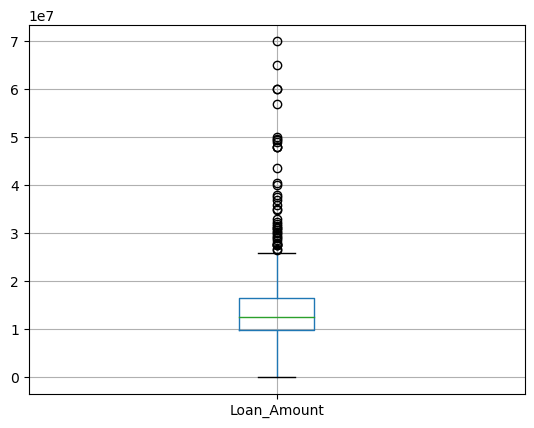

In [9]:
encode_num[['Loan_Amount']].boxplot()

<AxesSubplot:>

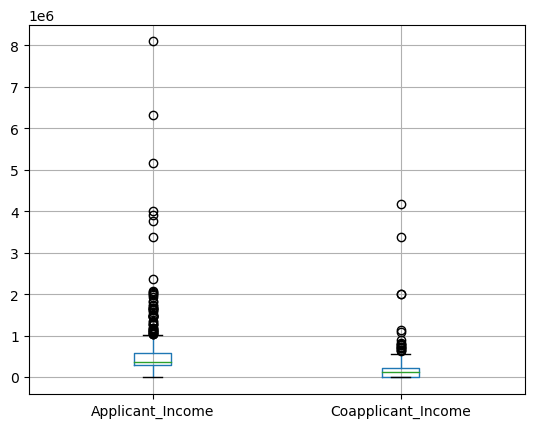

In [10]:
encode_num[["Applicant_Income","Coapplicant_Income"]].boxplot()

<AxesSubplot:>

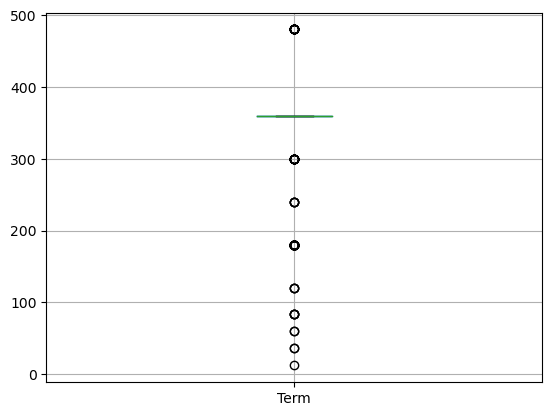

In [11]:
encode_num[['Term']].boxplot()

- log로 치환하기엔 0이 있어서 -inf 나올 가능성이 매우 커보임
- 그냥 두기엔 단위가 너무 크고 이상치로 분류되는 값들이 많음
- Term ..? -> 주기란 항목이 존재해서 왠지 주기별로 나누어 줘야할거같은 기분
- 한번 상관관계 파악해보자

<AxesSubplot:>

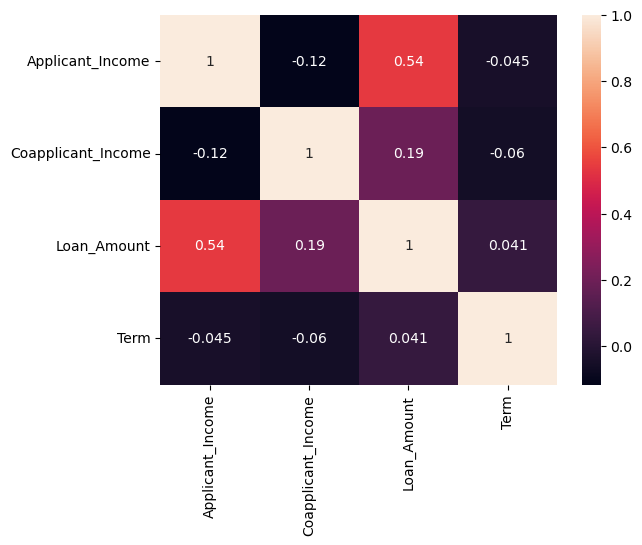

In [12]:
# seaborn으로 그린 히트맵
sns.heatmap(encode_num.corr(), annot=True)

In [13]:
# heatmap by pandas
encode_num.corr().style.background_gradient(cmap='summer')

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term
Applicant_Income,1.000000,-0.116605,0.539615,-0.045306
Coapplicant_Income,-0.116605,1.000000,0.189237,-0.059878
Loan_Amount,0.539615,0.189237,1.000000,0.041403
Term,-0.045306,-0.059878,0.041403,1.000000


- Applicant_Income과 Loan_Amount변수 간의 상관관계가 어느정도 있어보임 
- 일단은그대로 진행

### 데이터 단위 변경하기
- 돈단위를 변환하기 위해 각 income, loan을 1000, 10000으로 나눠줌

In [14]:
# 값을 1000단위로 바꿔주기
encode_num[["Applicant_Income", "Coapplicant_Income"]] /= 1000

# 대출금을 10000단위로 바꾸기
encode_num["Loan_Amount"] /= 10000

In [15]:
# 확인
encode_num.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term
count,614.000000,614.000000,614.000000,600.00000
mean,540.345928,162.124580,1414.104235,342.00000
std,610.904167,292.624837,881.568246,65.12041
min,15.000000,0.000000,0.000000,12.00000
25%,287.750000,0.000000,980.000000,360.00000
50%,381.250000,118.850000,1250.000000,360.00000
75%,579.500000,229.725000,1647.500000,360.00000
max,8100.000000,4166.700000,7000.000000,480.00000


<AxesSubplot:>

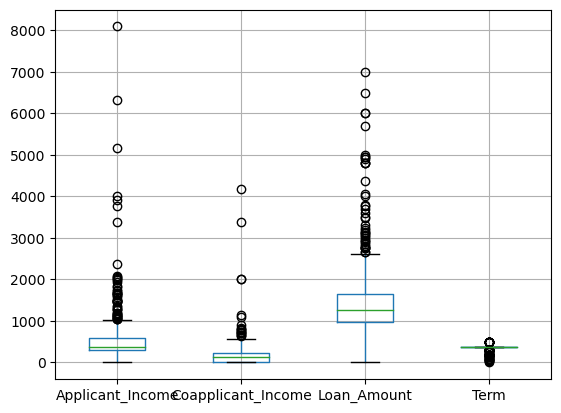

In [16]:
encode_num.boxplot()

- 이상치는 그대로지만 어느정도 갖춰져있는 형태를 확인할 수 있다.
- Term은 기간이기 때문에 그대로 적용시킬 반명 다른 변수는 이상치를 대치하는 것으로 적용할 예정

### 데이터 imputation

- Box Plot에서 보였던 변수들의 이상치를 먼저 결측치로 만든다.
- 결측치를 연속형 데이터는 평균, 범주형 데이터는 최빈값을 채운다.

In [17]:
# Q3, Q1을 통해 IQR을 계산
Q1 = encode_num[["Applicant_Income", "Coapplicant_Income", "Loan_Amount"]].quantile(q=0.25)
Q3 = encode_num[["Applicant_Income", "Coapplicant_Income", "Loan_Amount"]].quantile(q=0.75)
IQR = Q3-Q1

In [18]:
# 이상치를 결측치로 치환
for col in ["Applicant_Income", "Coapplicant_Income", "Loan_Amount"]:
    encode_num[col][(encode_num[col] > Q3[col]+1.5*IQR[col]) | (encode_num[col] < Q1[col]-1.5*IQR[col])] = np.nan

<AxesSubplot:>

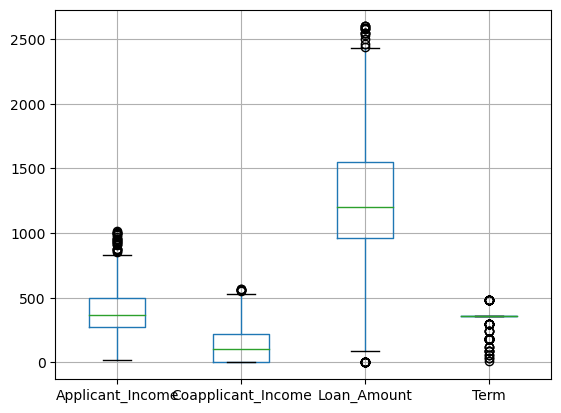

In [19]:
# 반영되었는지 확인
encode_num.boxplot()

- 이상치를 결측치로 치환한것이 잘 반영된 것을 확인
- MICE Reference : https://ichi.pro/ko/deiteo-seteueseo-gyeol-cheuggabs-eul-daechihaneun-mice-algolijeum-217004654686142

### 결측값 대치

#### 연속형

In [20]:
# MICE를 이용한 자동 대치
imputer_mice = IterativeImputer(random_state=42)
imputer_mice.fit(encode_num)

IterativeImputer(random_state=42)

In [21]:
# 데이터 변환 (array로 반환하기 때문에 필요에 맞는 형태로 변환 후 사용)
complete_num = pd.DataFrame(imputer_mice.transform(encode_num), columns=encode_num.columns)

#### 범주형

In [22]:
# 최빈값으로 Imputer 선언
imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_mode.fit(encode_cate)

SimpleImputer(strategy='most_frequent')

In [23]:
# 데이터 변환 (array로 반환하기 때문에 필요에 맞는 형태로 변환 후 사용)
complete_cate = pd.DataFrame(imputer_mode.transform(encode_cate), columns=encode_cate.columns)

### 범주형 변수 - LabelEncoding
- 결정트리 모델을 활용하기 때문에 이것으로 적용가능
- 결정트리가 아닐 경우 one-hot encoding 권장
- LabelEncoder는 한꺼번에 실행이 되지 않기 때문에 하나씩 사용

In [24]:
for col in complete_cate.columns:
    le = LabelEncoder() # 인코더 불러오기
    le.fit(complete_cate[col]) # 적합
    complete_cate[col] = le.transform(complete_cate[col])

### 연속형 변수 - Normalization Scaling

In [25]:
# StandardScaler객체 생성
scaler = StandardScaler()

In [26]:
# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(complete_num)
trans_num = scaler.transform(complete_num)

In [27]:
# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
trans_num_scaled = pd.DataFrame(data=trans_num, columns=encode_num.columns)

In [28]:
# test set에도 똑같은 값으로 적용해야하기 때문에 그대로 사용
print('feature 들의 표준화 평균 값')
print(trans_num.mean())
print('\nfeature 들의 표준화 표준편차 값')
print(trans_num.std())

feature 들의 표준화 평균 값
-3.1823982464825336e-17

feature 들의 표준화 표준편차 값
0.9999999999999999


### 데이터 결합

In [29]:
# 사용할 데이터 합치기
use_data = pd.concat([complete_cate, trans_num_scaled], axis = 1)

In [30]:
# 완성된 데이터 확인
use_data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Area,Applicant_Income,Coapplicant_Income,Loan_Amount,Term
0,1,0,0,0,0,1,2,0.878075,-0.898503,0.474823,0.280848
1,1,1,1,0,0,1,0,0.211270,0.143611,0.051807,0.280848
2,1,1,0,0,1,1,2,-0.622499,-0.898503,-1.140328,0.280848
3,1,1,0,1,0,1,2,-0.842134,0.731010,-0.102017,0.280848
4,1,0,0,0,0,1,2,0.957607,-0.898503,0.301771,0.280848


## 3. 데이터 불균형 확인과 데이터 분리

### y 데이터 불균형 확인

In [31]:
len(data_y[data_y == 'Y'])

422

In [32]:
len(data_y[data_y == 'N'])

192

- 422:192개로 데이터의 불균형이 보임 : 이를 SMOTE를 활용해 데이터 개수 맞춰주기

### SMOTE

In [33]:
# smote 불러오기
smote = SMOTE(random_state=42)

In [34]:
# 사용할 데이터 smote한 결과 불러오기
use_data_smote, y_smote = smote.fit_resample(use_data, data_y)

- 선정한 모델이 트리모형이기 때문에 0, 1로 변경
- 만일 SVM과 같은 모델이었다면 -1, 1로 바꿨을 예정

### Y변수 0, 1로 바꾸기

In [35]:
le = LabelEncoder() # 인코더 불러오기
le.fit(y_smote) # 적합
y_smote = le.transform(y_smote)

### Train/ Valid 데이터로 나누기

In [36]:
# 데이터 분류
train_x, valid_x, train_y, valid_y = train_test_split(use_data_smote, 
                                                      y_smote,
                                                      test_size=0.2,
                                                      random_state=42)

## 4. 모델

### 모델 적합

In [37]:
# 모델 불러오기
rf = RandomForestClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgb = LGBMClassifier(random_state = 42)

In [38]:
# 각 모델 학습
rf.fit(train_x, train_y)
xgb.fit(train_x, train_y)
lgb.fit(train_x, train_y)

LGBMClassifier(random_state=42)

In [39]:
# valid 대입
rf_predict = rf.predict(valid_x)
xgb_predict = xgb.predict(valid_x)
lgb_predict = lgb.predict(valid_x)

## 5. 결과 확인 및 평가지표 산출

### Confusion Matrix

- sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
- y_true, y_pred 순으로 대입해야함

In [40]:
# RF CM
confusion_matrix(valid_y, rf_predict)

array([[71, 23],
       [10, 65]], dtype=int64)

In [41]:
# XGB CM
confusion_matrix(valid_y, xgb_predict)

array([[72, 22],
       [11, 64]], dtype=int64)

In [42]:
# LGBM CM
confusion_matrix(valid_y, lgb_predict)

array([[70, 24],
       [11, 64]], dtype=int64)

### Scoring

In [43]:
# Rf score
print(classification_report(valid_y, rf_predict, target_names=['N', 'Y']))

              precision    recall  f1-score   support

           N       0.88      0.76      0.81        94
           Y       0.74      0.87      0.80        75

    accuracy                           0.80       169
   macro avg       0.81      0.81      0.80       169
weighted avg       0.82      0.80      0.81       169



In [44]:
# XGB score
print(classification_report(valid_y, xgb_predict, target_names=['N', 'Y']))

              precision    recall  f1-score   support

           N       0.87      0.77      0.81        94
           Y       0.74      0.85      0.80        75

    accuracy                           0.80       169
   macro avg       0.81      0.81      0.80       169
weighted avg       0.81      0.80      0.81       169



In [45]:
# LGBM score
print(classification_report(valid_y, lgb_predict, target_names=['N', 'Y']))

              precision    recall  f1-score   support

           N       0.86      0.74      0.80        94
           Y       0.73      0.85      0.79        75

    accuracy                           0.79       169
   macro avg       0.80      0.80      0.79       169
weighted avg       0.80      0.79      0.79       169



### AUC

In [46]:
roc_auc_score(valid_y, rf_predict)

0.8109929078014184

In [47]:
roc_auc_score(valid_y, xgb_predict)

0.8096453900709221

In [48]:
roc_auc_score(valid_y, lgb_predict)

0.7990070921985817

- 평가지표를 전부 비교했을 때 XGB가 성능이 가장 좋은것을 확인할 수 있었다.
- 따라서 XGB를 활용해 예측값을 구하고 Submission을 만든다.

## 6. test set 예측값 구하기

### test 데이터 연속형 및 범주형 분리

In [49]:
# 변수의 속성에 따라 분리하기
test_cate = pd.DataFrame() # 범주변수 저장
test_num = pd.DataFrame() # 연속 변수 저장
for attribute, col in zip(test.dtypes, test.columns): # 변수 타입과 열 이름
    if attribute == 'object' and col != 'Status': # Y변수는 별도로 시킬것이므로 제외
        test_cate[col] = test[col] # 범주형 변수
    elif col != 'Status':
        test_num[col] = test[col] # 연속 변수

### test 데이터 단위 변경

In [50]:
# 값을 1000단위로 바꿔주기
test_num[["Applicant_Income", "Coapplicant_Income"]] /= 1000

# 대출금을 10000단위로 바꾸기
test_num["Loan_Amount"] /= 10000

### 이상치를 결측치로

In [51]:
# 이상치를 결측치로 치환
for col in ["Applicant_Income", "Coapplicant_Income", "Loan_Amount"]:
    test_num[col][(test_num[col] > Q3[col]+1.5*IQR[col]) | (test_num[col] < Q1[col]-1.5*IQR[col])] = np.nan

### 결측치 대치

In [52]:
# 연속형
complete_test_num = pd.DataFrame(imputer_mice.transform(test_num), columns=test_num.columns)

In [53]:
# 범주형
complete_test_cate = pd.DataFrame(imputer_mode.transform(test_cate), columns=test_cate.columns)

### 변수 변환

#### 범주형

In [54]:
# 범주형 변환
for col in complete_cate.columns:
    le = LabelEncoder() # 인코더 불러오기
    le.fit(complete_test_cate[col]) # 적합
    complete_test_cate[col] = le.transform(complete_test_cate[col])

#### 연속형

In [55]:
# 연속형 변환
trans_test_num = scaler.transform(complete_test_num)
trans_test_num_scaled = pd.DataFrame(data=trans_test_num, columns=test_num.columns)

### 데이터 융합

In [56]:
# pd.concat
use_test = pd.concat([complete_test_cate, trans_test_num_scaled], axis = 1)

### 데이터 예측

In [57]:
test_predict = xgb.predict(use_test)
t = test_predict.astype(object)

### 예측값 저장

In [58]:
t

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,

In [59]:
# 기존의 N, Y값으로 다시 변환
t[t == '1'] = 'Y'
t[t == "0"] = 'N'

In [60]:
# 인덱스가 존재하지 않기 때문에 그냥 만들어서 대입해준다.
# t.to_csv('submission.csv', index=True)